In [7]:
import numpy as np
import subprocess as sub
import os
import time
from matplotlib import pyplot as plt


In [1]:
from rfast_interface import RfastInterface

In [2]:
r = RfastInterface()

In [3]:
species = ['CH4','CO2','H2O','O2','O3','N2O','CO']
cia = ['N2','O2']

r.set_line_cia_species(species, cia)

In [4]:
outdir = "/Users/nicholas/Documents/Research_local/NASA/NominalArchean/test_dir/test1"

r.spawn_retieval(outdir)

In [12]:
48/(2*4)

6.0

In [9]:
0.75*.2+0.75

0.9

In [8]:
total = len(r.processes)

number_completed = 0
for process in r.processes:
    res = process.poll()
    if res != None:
        number_completed += 1

fmt = "{:50}"

print(fmt.format("completed/total = "+str(number_completed)+'/'+str(total)),end='\r')

In [10]:
wavl = [0.2,2.0]
res = [140]
modes = [1]
snr0 = [20]

r.set_wavelength_grid(wavl, res, modes, snr0)

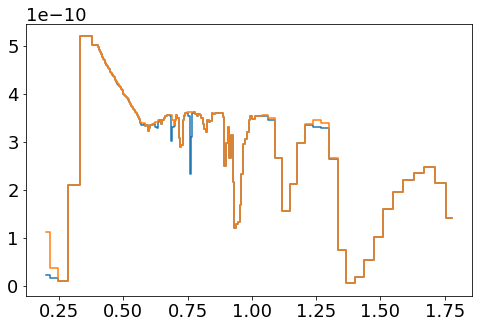

In [10]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[8,5])
fig.patch.set_facecolor("w")

ax.plot(out['wv'],out['flux_ratio'], drawstyle='steps-mid')
ax.plot(out_noO2['wv'],out_noO2['flux_ratio'], drawstyle='steps-mid')

plt.show()

In [67]:
def bandpass_extents(B, lam_c):
    Dlam = B*lam_c/(1+B*0.5)
    lam_min = lam_c - 0.5*Dlam
    lam_max = lam_c + 0.5*Dlam
    return lam_min, lam_max, Dlam

def make_filenames(root_outdir, prefix, B, res, snr):
    fns_name = \
    prefix+"_"+('B=%.4f'%B)+"_"+('res=%.4f'%res)+"_"+('snr=%.4f'%snr)
    fnn_name = fns_name+'_n'
    fnr_name = fns_name+'_r'
    
    out = {}
    out['output_folder'] = root_outdir+'/'+fns_name
    # set the filenames
    out['fns'] = out['output_folder']+'/'+fns_name
    out['fnn'] = out['output_folder']+'/'+fnn_name
    out['fnr'] = out['output_folder']+'/'+fnr_name
    
    out['rfast_inputs'] = out['output_folder']+'/'+fns_name+'_inputs.scr'
    out['rfast_rpars'] = out['output_folder']+'/'+fns_name+'_rpars.txt'
    return out

def add_extensions_to_files(fns, fnn, fnr):
    fns_raw = fns + '.raw'
    fnn_dat = fnn + '.dat'
    fnr_h5 = fnr + '.h5'
    return fns_raw, fnn_dat, fnr_h5


def make_dirs_and_files(B, res, snr, root_outdir, prefix):
    # variables to set
    # fns
    # fnn
    # fnr
    # lams
    # laml
    # res
    # snr0

    # read template inputs file
    with open(TEMPLATE_INPUTS,'r') as f:
        lines = f.readlines()

    out_files = make_filenames(root_outdir, prefix, B, res, snr)
    lam_min, lam_max, Dlam = bandpass_extents(B, LAM_C)

    new_lines = []
    for line in lines:
        tmp = line
        v = line.strip().split()[0]
        if v == 'fns':
            tmp = "fns       = "+out_files['fns']+'\n'
        if v == 'fnn':
            tmp = "fnn       = "+out_files['fnn']+'\n'
        if v == 'fnr':
            tmp = "fnr       = "+out_files['fnr']+'\n'
        if v == 'lams':
            tmp = "lams      = "+LAMS_PREFIX+"%.4f"%lam_min+'\n'
        if v == 'laml':
            tmp = "laml      = "+LAML_PREFIX+"%.4f"%lam_min+",""%.4f"%lam_max+'\n'
        if v == 'res':
            tmp = "res       = "+RES_PREFIX+"%i"%res+'\n'
        if v == 'snr0':
            tmp = "snr0      = "+SNR0_PREFIX+"%i"%snr+'\n'
        new_lines.append(tmp)

    # make the directories and files
    if not os.path.isdir(root_outdir):
        raise Exception('"'+root_outdir+'" does not exist.')

    # if output directory does not exist
    # then we create it
    if os.path.isdir(out_files['output_folder']):
        raise Exception('"'+out_files['output_folder']+'" already exists!')
    else:
        os.mkdir(out_files['output_folder'])

    # write the input file
    with open(out_files['rfast_inputs'],'w') as f:
        for line in new_lines:
            f.write(line)

    # write the rpars file
    with open(TEMPLATE_RPARS,'r') as f:
        lines = f.readlines()
    with open(out_files['rfast_rpars'],'w') as f:
        for line in lines:
            f.write(line)
            
    return out_files

def monitor_processes(all_process):
    start = time.time()
    total = len(all_process)
    while True:
        number_completed = 0
        for process in all_process:
            res = process.poll()
            if res != None:
                number_completed += 1

        fmt = "{:50}"

        print(fmt.format("completed/total = "+str(number_completed)+'/'+str(total)),end='\r')
        if number_completed == total:
            break
        else:
            time.sleep(REFRESH_TIME)
            
        finish = time.time()
        runtime = finish-start
        # we time out after a bit.
        if runtime > TIMEOUT:
            print("TIMEOUT reached. Killing all processes.")
            for process in all_process:
                process.kill()
            
def spawn_retrieval(files):
    # run genspec
    cmd = "python rfast_genspec.py "+files['rfast_inputs']
    res = sub.run(cmd.split(),check=True,cwd=RFAST_ROOT)

    # run noise
    cmd = "python rfast_noise.py "+files['rfast_inputs']
    res = sub.run(cmd.split(),check=True,cwd=RFAST_ROOT)

    # initialize retreival
    cmd = "python rfast_initret.py "+files['rfast_inputs']+' '+files['rfast_rpars']
    res = sub.run(cmd.split(),check=True,cwd=RFAST_ROOT)
    
    cmd = "python rfast_retrieve.py "+files['rfast_inputs']
    process = sub.Popen(cmd.split(),cwd=RFAST_ROOT)
    # just wait for 1 second!
    time.sleep(1)
    
    return process

def spawn_rfast_retreivals(B, res, snr, root_outdir, prefix):
    all_process = []
    for i in range(len(B)):
        files = make_dirs_and_files(B[i], res[i], snr[i], root_outdir, prefix)
        process = spawn_retrieval(files)
        all_process.append(process) 
    monitor_processes(all_process)

In [35]:
# constants
LAM_C = 0.95 # center
TEMPLATE_FOLDER = "/Users/nicholas/Documents/Research_local/NASA/NominalArchean/NA_rfast/"
TEMPLATE_INPUTS = TEMPLATE_FOLDER+"NA_inputs_template.scr"
TEMPLATE_RPARS = TEMPLATE_FOLDER+"NA_rpars.txt"
RFAST_ROOT = "/Users/nicholas/Documents/Research_local/NASA/NominalArchean/rfast"
LAMS_PREFIX = "0.5,0.6,"
LAML_PREFIX = "0.6,"
RES_PREFIX = "0,0,"
SNR0_PREFIX = "7,0.01,"
REFRESH_TIME = 5 # seconds
TIMEOUT = 60*60*24 # 1 day

# these are the inputs
root_outdir = "/Users/nicholas/Documents/Research_local/NASA/NominalArchean"
prefix = "MA"
B = 0.2
res = 70
snr = 10

In [79]:


def make_input_lists(B_1, res_1, snr_1):
    B = []
    res = []
    snr = []
    for b in B_1:
        for r in res_1:
            for s in snr_1:
                B.append(b)
                res.append(r)
                snr.append(s)
    return B,res,snr

In [90]:
B_1 = [0.15, 0.2]
res_1 = [70, 140]
snr_1 = [5, 10, 15, 20] 
B,res,snr = make_input_lists(B_1, res_1, snr_1)


In [92]:
B_1

[0.15, 0.2]

In [93]:
total_time = 60*60*2
total_time*4

28800

In [97]:
mb_pr_iter = 35/1000
mb_pr_iter*17000*16/1000

9.52